# Intro

We use the [Kaggle Dataset "House Prices"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) to show an example how to use ML Aide.

In [11]:
## for data
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [12]:
dtf = pd.read_csv("data/data_houses.csv")
cols = ["OverallQual","GrLivArea","GarageCars", 
        "GarageArea","TotalBsmtSF","FullBath",
        "YearBuilt","YearRemodAdd",
        "LotFrontage","MSSubClass"]
dtf = dtf[["Id"] + cols + ["SalePrice"]]

dtf.head()

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,LotFrontage,MSSubClass,SalePrice
0,1,7,1710,2,548,856,2,2003,2003,65.0,60,208500
1,2,6,1262,2,460,1262,2,1976,1976,80.0,20,181500
2,3,7,1786,2,608,920,2,2001,2002,68.0,60,223500
3,4,7,1717,3,642,756,1,1915,1970,60.0,70,140000
4,5,8,2198,3,836,1145,2,2000,2000,84.0,60,250000


In [13]:
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

# Data Visualization

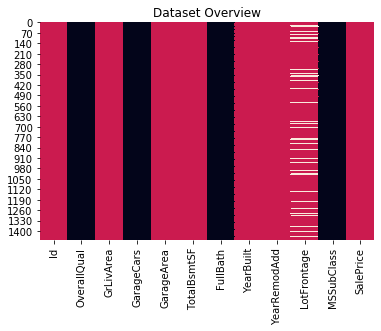

 Categerocial   Numeric   NaN 


In [14]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=20) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
  if v == "num":
    heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
  else:
    heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [15]:
dtf = dtf.set_index("Id")
dtf = dtf.rename(columns={"SalePrice":"Y"})

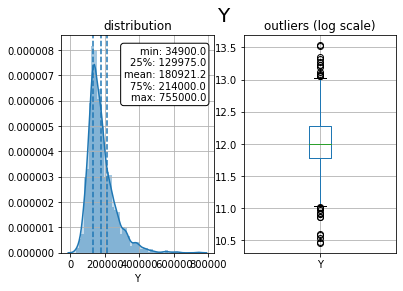

In [16]:
x = "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

# Data Preprocessing

In [17]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (1022, 10) | X_test shape: (438, 10)
y_train mean: 179430.18 | y_test mean: 184400.24
11 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'MSSubClass']


### Fill missing LotFrontage values with the mean

In [18]:
dtf_train["LotFrontage"] = dtf_train["LotFrontage"].fillna(dtf_train["LotFrontage"].mean())

### Encode categorical data

In [19]:
## create dummy
dummy = pd.get_dummies(dtf_train["MSSubClass"], prefix="MSSubClass_cluster", drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
print(dtf_train.filter(like="MSSubClass",axis=1).head())

## drop the original categorical column
dtf_train = dtf_train.drop("MSSubClass", axis=1)

      MSSubClass  MSSubClass_cluster_30  MSSubClass_cluster_40  \
Id                                                               
862          190                      0                      0   
952           20                      0                      0   
1173         160                      0                      0   
1135          60                      0                      0   
1155          60                      0                      0   

      MSSubClass_cluster_45  MSSubClass_cluster_50  MSSubClass_cluster_60  \
Id                                                                          
862                       0                      0                      0   
952                       0                      0                      0   
1173                      0                      0                      0   
1135                      0                      0                      1   
1155                      0                      0                      1  

### Scale features

In [21]:
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dtf_scaled[y] = scalerY.fit_transform(dtf_train[y].values.reshape(-1,1))
dtf_scaled.head()

NameError: name 'y' is not defined